#  INIT

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../infras/cellMix/')
sys.path.append('../infras/dashboards/')

In [2]:
from cellMix_coordinator import CellMixCoordinator

In [3]:
import exploration_plots
import dashs

In [4]:
import pandas as pd
import numpy as np
from functools import partial
import multiprocessing

from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from functools import partial
from scipy.optimize import minimize
import scipy.optimize
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [5]:
from deconv_py.preprocess.base import BasePreprocess as PP_base
from deconv_py.preprocess.cell_specific import CellSpecific as PP_proteins

from deconv_py.infras.data_factory import DataFactory
from deconv_py.infras.data_loader import DataLoader

from deconv_py.models.base import Base as Models_base
from deconv_py.models.cell_proportions_models import CellProportions
from deconv_py.models.cell_specific_models import CellSpecificPerPermutation

from deconv_py.experiments.cell_specific import CellSpecificMetricsPlot

# from deconv_py.infras.cellMix.cellMix_coordinator import CellMixCoordinator

In [6]:
data_loader = DataLoader(mass_spec_path=os.path.abspath('../data/20150208_mixture_proteinGroups.xls'),
                         protein_profile_path = os.path.abspath('../data/20150718_Cerberus_proteinGroups.txt'))


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# exploration - intensities

## read data - intensities

### mixture & cell specific data

In [18]:
relvent_data = ['Intensity NOT_BCellmemory_01', 'Intensity NOT_BCellnaive_01', 'Intensity NOT_BCellplasma_01', 'Intensity NOT_CD4TCellmTregs_01',
 'Intensity NOT_CD4TCellnaive_01', 'Intensity NOT_CD4TCellnTregs_01', 'Intensity NOT_CD4TCellTcm_01', 'Intensity NOT_CD4TCellTem_01',
 'Intensity NOT_CD4TCellTemra_01', 'Intensity NOT_CD4TCellTh1_01', 'Intensity NOT_CD4TCellTh17_01', 'Intensity NOT_CD4TCellTh2_01',
 'Intensity NOT_CD8TCellnaive_01', 'Intensity NOT_CD8TCellTcm_01', 'Intensity NOT_CD8TCellTem_01', 'Intensity NOT_CD8TCellTemra_01',
 'Intensity NOT_DendriticCD1c_01', 'Intensity NOT_DendriticCD304_01', 'Intensity NOT_Erythrocytes_01', 'Intensity NOT_GranulocytesBasophil_01',
 'Intensity NOT_Granulocyteseosinophils_01', 'Intensity NOT_Granulocytesneutrophils_01', 'Intensity NOT_Monocytesclassical_01', 'Intensity NOT_Monocytesintermediate_01',
 'Intensity NOT_Monocytesnonclassical_01', 'Intensity NOT_NKCellsCD56bright_01', 'Intensity NOT_NKCellsCD56dim_01', 'Intensity NOT_Thrombocytes_01']
data_loader = DataLoader(mass_spec_path=os.path.abspath('../data/20190801_filtered_imputed_data.csv'),
                         protein_profile_path = os.path.abspath('../data/20150718_Cerberus_proteinGroups.txt'),as_csv = True)
ms = data_loader.get_mass_spec_data()

data_factory = DataFactory(data_loader)
profile_data,profile_data_relvent_data = data_factory.build_cell_specific_profile(auto_filter_by=False,relvent_data=relvent_data,relvent_columns=["Majority protein IDs","Gene names"])
mixtures,mixtures_relvent_data = data_factory.build_mixture_data(relvent_data=[pb for pb in ms.columns if "_v1" in pb],relvent_columns=["Majority protein IDs"],auto_filter_by=False,log2_transformation=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## build A ,X and B 

### set unique index

In [8]:
index_func = lambda x:x.split(';')[0]
_profile_data,_mixtures = PP_base.return_mutual_proteins_by_index(profile_data,mixtures,index_func=index_func)
A = _profile_data[profile_data_relvent_data]
B = _mixtures[mixtures_relvent_data]
# X = cell_proportions_df

In [9]:
# B=B.rename({f:f.split('Intensity ')[1] for f in B.columns},axis=1)

# X = X.rename({f:f.split('Intensity ')[1] for f in X.index},axis=0)
# X = X.rename({f:'mixture'+str(f) for f in X.columns},axis=1)

A = A.rename({f:f.split('Intensity ')[1] for f in A.columns},axis=1)

## intensities analysis

### distributions

../infras/dashboards\exploration_plots.py:18: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  df = res.reindex_axis(indexes, axis=0)
../infras/dashboards\dashs.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exploration_plots.values_histogram_per_cell_profile(A)


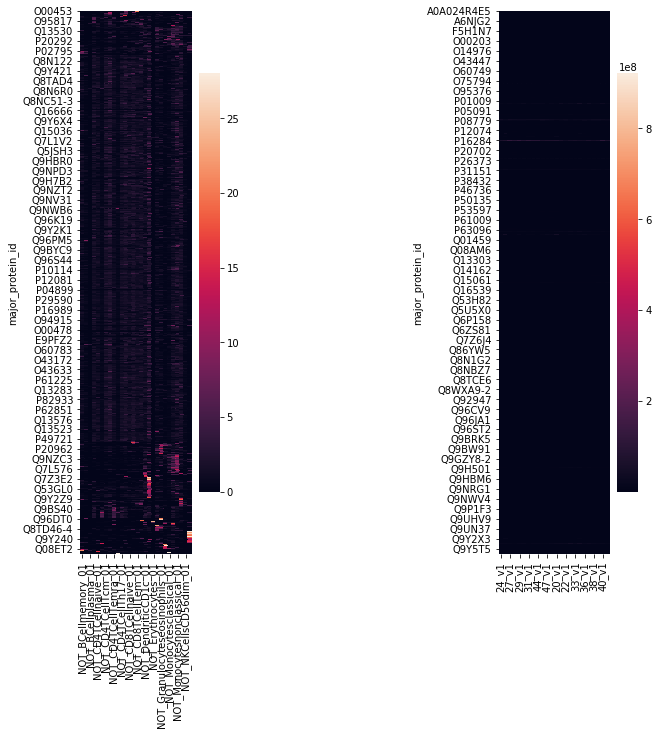

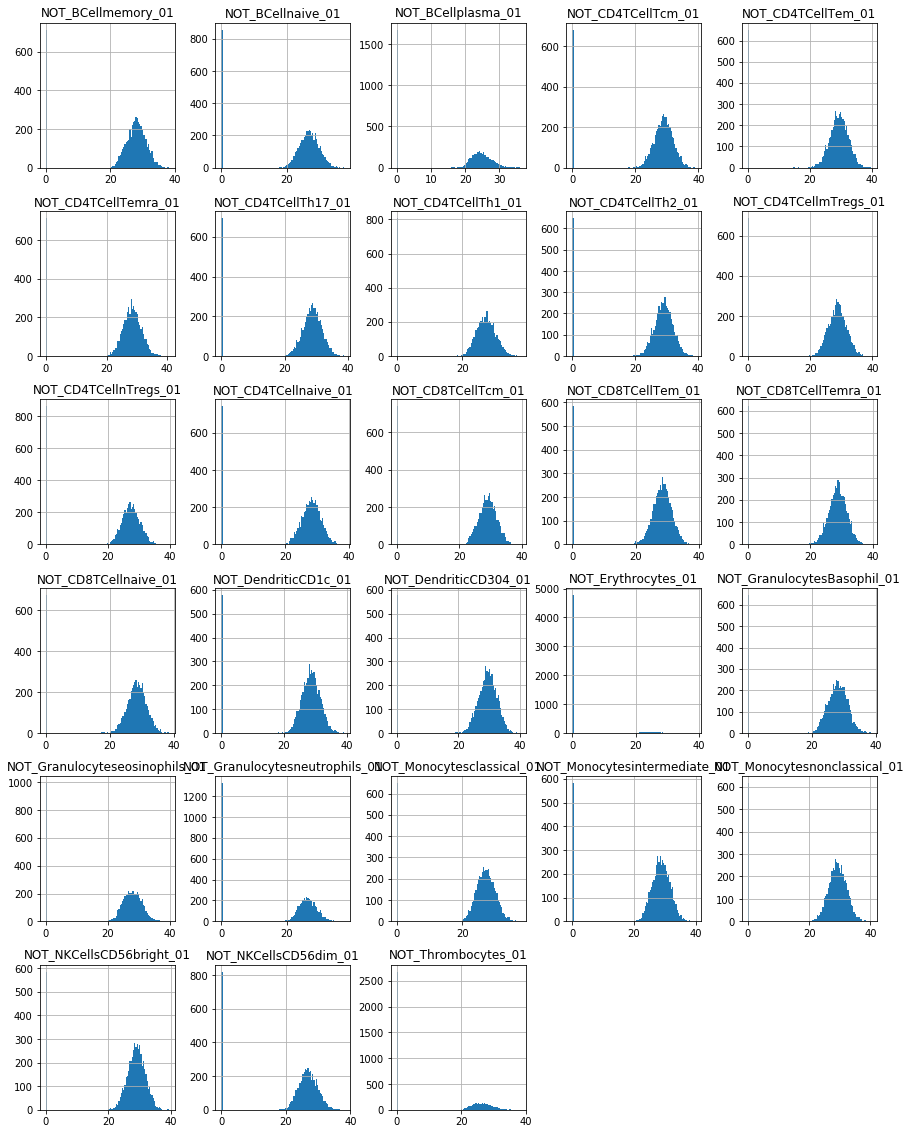

In [10]:
dashs.cells_profile_dash(A,None,B)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


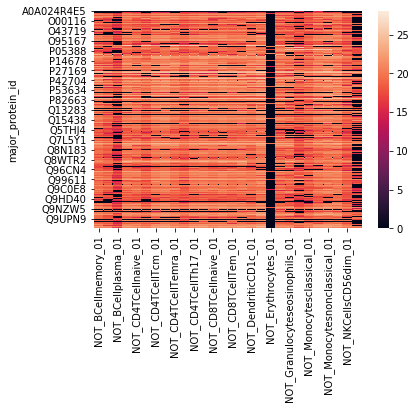

In [11]:
from scipy.stats import entropy
_A = A.copy(deep=True)
entropys = _A.apply(lambda x:entropy(x),axis=1)
entropys = entropys.fillna(0)
entropy_selected_prot = entropys[entropys > entropys.quantile(0.01)]
_A = _A.ix[entropy_selected_prot.index]
# dashs.cells_profile_dash(_A,None,None)
sns.heatmap(np.log(1+_A))

In [12]:
#number oz zeros in every cell
is_zero_A = A ==0 
(is_zero_A.sum()/is_zero_A.count()).sort_values(ascending  = False)

NOT_Erythrocytes_01               0.894560
NOT_Thrombocytes_01               0.500093
NOT_BCellplasma_01                0.313517
NOT_Granulocytesneutrophils_01    0.247149
NOT_Granulocyteseosinophils_01    0.185455
NOT_CD4TCellnTregs_01             0.161152
NOT_BCellnaive_01                 0.160217
NOT_NKCellsCD56dim_01             0.153300
NOT_CD4TCellTh1_01                0.151243
NOT_CD4TCellnaive_01              0.138531
NOT_CD8TCellTcm_01                0.137783
NOT_CD4TCellTemra_01              0.133857
NOT_BCellmemory_01                0.133670
NOT_CD4TCellTh17_01               0.129931
NOT_CD4TCellmTregs_01             0.128809
NOT_CD4TCellTcm_01                0.127687
NOT_CD8TCellnaive_01              0.126005
NOT_CD4TCellTem_01                0.121892
NOT_CD4TCellTh2_01                0.121331
NOT_Monocytesclassical_01         0.121144
NOT_GranulocytesBasophil_01       0.120957
NOT_CD8TCellTemra_01              0.115723
NOT_Monocytesnonclassical_01      0.114975
NOT_NKCells

## result analysis

### zero entropy cells

In [81]:
_A, _B = PP_proteins.pp_clean_irrelevant_proteins(A.copy(deep=True), B.copy(deep=True))
_A_norm = _A.div(_A.sum(axis=1),axis=0)

only_zero_entropy = _A[_A_norm.apply(lambda gene_dis:entropy(gene_dis),axis=1)==0]

_filt_A = _A.loc[only_zero_entropy.index]
_filt_B =_B.loc[only_zero_entropy.index]

non_zero_cells = _filt_A.loc[:, (_filt_A != 0).any(axis=0)].columns
_filt_A = _filt_A[non_zero_cells.tolist()]

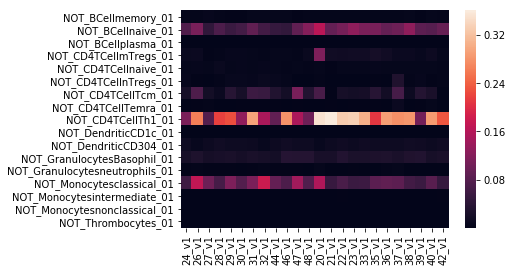

In [82]:
computed_proportions = CellProportions.fit_as_df(_filt_A,_filt_B,normalize = False)
sns.heatmap(computed_proportions)

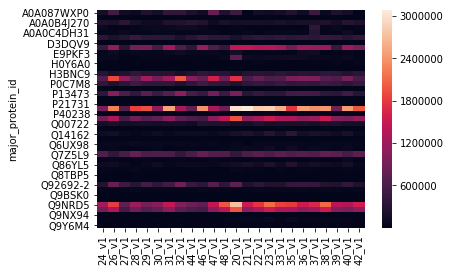

In [83]:
computed_mixtures = _filt_A.dot(computed_proportions)
sns.heatmap(computed_mixtures)

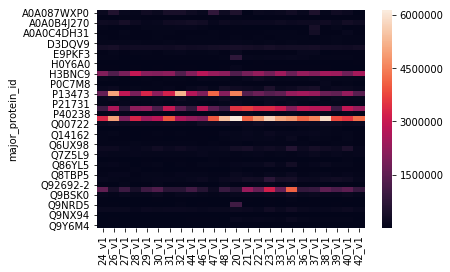

In [84]:
corresponding_real_mixture = _filt_B[computed_mixtures.columns].loc[computed_mixtures.index]
sns.heatmap(corresponding_real_mixture)

### expected vs real -  zero entropy

In [ ]:
import matplotlib.colors as mcolors

pos_colors = list(mcolors.CSS4_COLORS.keys())
cell_to_color_map = {cell: color for cell, color in zip(_A.columns,pos_colors[::5] )}
list_of_dfs = []
for mixture in corresponding_real_mixture.columns:
    df = pd.DataFrame(columns=["computed","real"])
    df["computed"] = computed_mixtures[mixture]
    df["real"] = corresponding_real_mixture[mixture]
    list_of_dfs.append(df)

final_df = pd.concat(list_of_dfs)
final_df = final_df.merge(_filt_A.idxmax(axis=1).to_frame(),left_index=True,right_index=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for gene,point in final_df.iterrows():
    label = point[0]
    color = cell_to_color_map[label]
    _real = point["real"]
    _computed = point["computed"]
    ax.plot(_real,_computed,'o',color=color,label=label)
# ax.set_xlim(0,30)
# ax.set_ylim(0,30)
ax.set_title("genes in real vs deconv mixtures")
ax.set_xlabel("real data")
ax.set_ylabel("Deconv data")

handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), loc=(0, 1.08))

plt.show()
# ax.scatter(final_df["computed"],final_df["real"],c = [cell_to_color_map[p] for p in final_df[0]],label=final_df[0])


In [ ]:
n_distinct_genes = (only_zero_entropy != 0 ).sum()


cell_to_color_map = {idx: color for idx, color in zip(range(A.shape[1]),pos_colors[::5] )}

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for gene,point in final_df.iterrows():
    label = n_distinct_genes.loc[point[0]]
    color = cell_to_color_map[label]
    _real = point["real"]
    _computed = point["computed"]
    ax.plot(_real,_computed,'o',color=color,label=label)
# ax.set_xlim(0,30)
# ax.set_ylim(0,30)

ax.set_title("genes in real vs deconv mixtures")
ax.set_xlabel("real data")
ax.set_ylabel("Deconv data")

handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), loc=(0, 1.14))

plt.show()


### distribution of mixtures per gene

In [ ]:
ambiguous_cells = n_distinct_genes.loc[n_distinct_genes>1]

In [ ]:
fig,axs = plt.subplots(4,2,figsize=(25,25))

for cell,ax in zip(ambiguous_cells.index,axs.reshape(-1)):
    cell_zero_entropy = only_zero_entropy[cell]
    cell_zero_entropy = cell_zero_entropy.loc[cell_zero_entropy!=0]
    
    df = pd.DataFrame(columns=cell_zero_entropy.index,index=_B.columns)
    for gene,count in cell_zero_entropy.iteritems():
        df[gene] = _B.loc[gene]/count
    
    sns.boxplot( data=df,whis="range", palette="vlag",ax=ax)
    ax.set_title(cell)
    
    ax.set_ylabel("proportion")
plt.show()
